# IMMC 2020: With Variable Heuristic and Proper Product List
### Importing Modules and Data

In [55]:
import pandas as pd
import copy
import re
import random
import math, statistics
import numpy as np
import gc
import matplotlib.pyplot as plt
from pprint import pprint

median_income = 9733/365
loss_aversion_coefficient = 2
max_shelf_capacity = 150
max_pdt_per_shelf = 1
units_per_object = 3
crowd_avoidance = 0.5

pdt_csv_data = pd.read_csv("StoreData_IMMC_CSV.csv")
print(pdt_csv_data.head())

          department product_category       product_type     brand  \
0    TV&Home Theater   TVS 30" to 45"    1080p LED Smart  Brand BB   
1  Computers&Tablets          Laptops  2-in-1 Chromebook   Brand A   
2  Computers&Tablets          Laptops  2-in-1 Chromebook  Brand BB   
3  Computers&Tablets          Laptops  2-in-1 Chromebook   Brand G   
4  Computers&Tablets          Laptops  2-in-1 Chromebook   Brand P   

                                                name  initial_price  \
0                 40" 1080p Smart LED HDTV, 5 Series         259.99   
1  2-in-1 11.6" Touch-Screen Chromebook, Intel Ce...         279.99   
2  2-in-1 12.2" Touch-Screen Chromebook, Intel Ce...         449.00   
3  2-in-1 14" Touch-Screen Chromebook, Intel Core...         549.00   
4  2-in-1 14" Touch-Screen Chromebook, Intel Core...         599.00   

   discounted_price  qty  customer_rating  brand_rating  percentage_usage  \
0            179.99    8              4.7      4.623810              0.95  

In [56]:
def sigmoid(x):
    return 1 / (1 + math.exp(-x))

## Determining the Popularity of Product
### Impact of Discount on Popularity

In [57]:
# Traditional Econs Approach
def q1_over_q0(p0, p1, percentage_usage):
    x = (p0 - p1)*(percentage_usage/median_income) 
    return (math.exp(x))

# Behavioural Econs Approach
def prospect_utility(x):
    if x > 0:
        return(math.log(x+1))
    else:
        return(-loss_aversion_coefficient * math.log(-x + 1))

def increase_utility(p0, p1):
    return(prospect_utility(p0 - p1))

# Helper Variables
max_increase_utility = increase_utility(3329.99, 2199.99)
min_increase_utility = 0
max_q1_over_q0 = q1_over_q0(3329.99, 2199.99, 1)
min_q1_over_qo = 1

# Combined Effect [Between 0 and 1]
def popularity_due_to_discount(p0, p1, percentage_usage):
    traditional_econs_adjusted = (q1_over_q0(p0, p1, percentage_usage)-min_q1_over_qo)/max_q1_over_q0
    behavioural_econs_adjusted = (increase_utility(p0, p1)-min_increase_utility)/max_increase_utility

    total_adjusted = statistics.mean([traditional_econs_adjusted, behavioural_econs_adjusted])
    return(total_adjusted)

### Effect of Loss Adversion on Popularity

In [58]:
# [Between 0 and 1]
def popularity_due_to_loss_aversion(qty):
    return(math.exp(-qty/loss_aversion_coefficient))

### Effects of Saliency Bias on Popularity (TO DO)

In [59]:
def popularity_due_to_saliency_bias(size, qty):
    return sigmoid(size*qty)

### Effects of Ratings on Popularity

In [60]:
# [Between 0 and 1]
def popularity_due_to_rating(pdt_rating, brand_rating):
    raw_brand = (0.8*pdt_rating + 0.2*brand_rating)
    return(raw_brand/5)

## Creating Product Class and List

In [61]:
class product:
    # Popularity Coefficients
    pop_loss_adversion_coefficient = 0.44
    pop_saliency_coefficient = 0.6
    pop_rating_coefficient = 0.5
    
    
    # Raw Data
    def __init__(self, index, name, department, product_category, product_type, brand, initial_price, discounted_price, qty, customer_rating, brand_rating=5, percentage_usage=0.5, size=20):
        self.name = name
        self.index = index
        self.department = department
        self.product_category = product_category
        self.product_type = product_type
        self.brand = brand
        self.initial_price = initial_price
        self.discounted_price = discounted_price
        self.qty = qty
        self.customer_rating = customer_rating
        self.brand_rating = brand_rating
        self.percentage_usage = percentage_usage
        self.size = size
        
        self.popularity = 0
    
    # Processed Data
    
    def set_popularity(self):
        discount_factor = popularity_due_to_discount(self.initial_price, self.discounted_price, self.percentage_usage)
        loss_adversion_factor = popularity_due_to_loss_aversion(self.qty)
        saliency_factor = popularity_due_to_saliency_bias(self.size, self.qty)
        rating_factor = popularity_due_to_rating(self.customer_rating, self.brand_rating)
        
        initial_popularity = self.pop_loss_adversion_coefficient*loss_adversion_factor + self.pop_saliency_coefficient*saliency_factor + self.pop_rating_coefficient*rating_factor
        self.popularity = sigmoid(initial_popularity + discount_factor)
        
        
        

In [62]:
# Populating the Product List
pdt_list = []
pdt_counter = 0
for index, row in pdt_csv_data.iterrows():
    
    total_qty = row["qty"]
    unit_size = row["index_size"]
    while True:
        
        cur_qty = min(min(int(max_shelf_capacity/unit_size), total_qty), units_per_object)
        print("index", index, "department", row["department"], "qty", cur_qty, "net_size", cur_qty*unit_size)
        total_qty -= cur_qty
        
        cur_pdt = product(index, row["name"], row["department"], row["product_category"], row["product_type"], row["brand"], row["initial_price"], row["discounted_price"], cur_qty, row["customer_rating"], size=unit_size, brand_rating=row["brand_rating"], percentage_usage=row["percentage_usage"])
        cur_pdt.set_popularity()
        
        pdt_counter += 1
        pdt_list.append(cur_pdt)
        
        if total_qty <=0:
            break

print("pdt_list len", len(pdt_list))
print("Number of products", pdt_counter)

index 0 department TV&Home Theater qty 3 net_size 6.038068754999999
index 0 department TV&Home Theater qty 3 net_size 6.038068754999999
index 0 department TV&Home Theater qty 2 net_size 4.02537917
index 1 department Computers&Tablets qty 3 net_size 0.3252653034
index 1 department Computers&Tablets qty 3 net_size 0.3252653034
index 1 department Computers&Tablets qty 3 net_size 0.3252653034
index 1 department Computers&Tablets qty 1 net_size 0.1084217678
index 2 department Computers&Tablets qty 3 net_size 0.3252653034
index 2 department Computers&Tablets qty 3 net_size 0.3252653034
index 2 department Computers&Tablets qty 2 net_size 0.2168435356
index 3 department Computers&Tablets qty 3 net_size 0.3252653034
index 3 department Computers&Tablets qty 3 net_size 0.3252653034
index 3 department Computers&Tablets qty 3 net_size 0.3252653034
index 3 department Computers&Tablets qty 1 net_size 0.1084217678
index 4 department Computers&Tablets qty 3 net_size 0.3252653034
index 4 department Comp

index 39 department Computers&Tablets qty 3 net_size 2.6665274229
index 39 department Computers&Tablets qty 3 net_size 2.6665274229
index 39 department Computers&Tablets qty 3 net_size 2.6665274229
index 39 department Computers&Tablets qty 3 net_size 2.6665274229
index 40 department Computers&Tablets qty 3 net_size 2.6665274229
index 40 department Computers&Tablets qty 3 net_size 2.6665274229
index 40 department Computers&Tablets qty 3 net_size 2.6665274229
index 40 department Computers&Tablets qty 3 net_size 2.6665274229
index 40 department Computers&Tablets qty 3 net_size 2.6665274229
index 41 department Computers&Tablets qty 3 net_size 2.6665274229
index 41 department Computers&Tablets qty 3 net_size 2.6665274229
index 41 department Computers&Tablets qty 3 net_size 2.6665274229
index 41 department Computers&Tablets qty 3 net_size 2.6665274229
index 41 department Computers&Tablets qty 3 net_size 2.6665274229
index 42 department Computers&Tablets qty 3 net_size 3.2650981679999997
inde

index 68 department Video Gaming qty 3 net_size 3.1156418699999997
index 68 department Video Gaming qty 3 net_size 3.1156418699999997
index 68 department Video Gaming qty 3 net_size 3.1156418699999997
index 69 department Video Gaming qty 3 net_size 3.1156418699999997
index 69 department Video Gaming qty 3 net_size 3.1156418699999997
index 69 department Video Gaming qty 3 net_size 3.1156418699999997
index 69 department Video Gaming qty 3 net_size 3.1156418699999997
index 69 department Video Gaming qty 3 net_size 3.1156418699999997
index 69 department Video Gaming qty 3 net_size 3.1156418699999997
index 69 department Video Gaming qty 2 net_size 2.07709458
index 70 department Computers&Tablets qty 3 net_size 2.6665274229
index 70 department Computers&Tablets qty 3 net_size 2.6665274229
index 70 department Computers&Tablets qty 3 net_size 2.6665274229
index 70 department Computers&Tablets qty 1 net_size 0.8888424743000001
index 71 department Computers&Tablets qty 3 net_size 2.6665274229
in

In [63]:
department_popularities = {
    "Appliances": 0,
    "Audio": 0,
    "Cameras": 0,
    "Cell Phones": 0,
    "Computers&Tablets": 0,
    "TV&Home Theater": 0,
    "Video Gaming": 0
}
department_qty = {
    "Appliances": 0,
    "Audio": 0,
    "Cameras": 0,
    "Cell Phones": 0,
    "Computers&Tablets": 0,
    "TV&Home Theater": 0,
    "Video Gaming": 0
}
for pdt in pdt_list:
    department_popularities[pdt.department]+= pdt.popularity*pdt.qty
    department_qty[pdt.department]+= pdt.qty

for department, total_pop in department_popularities.items():
    print("Department:", department, "Average Popularity", total_pop/department_qty[department])
    
    
print("--------")
total_objects = 0
for department, total_pop in department_popularities.items():
    number_of_objects = 0
    for pdt in pdt_list:
        if pdt.department == department:
            number_of_objects += 1
    total_objects += number_of_objects
    print("Department:", department, "Number of Objects", number_of_objects)
    
print("Total Number of Objects", total_objects)

Department: Appliances Average Popularity 0.8237294457073325
Department: Audio Average Popularity 0.7633075738636679
Department: Cameras Average Popularity 0.778664491286548
Department: Cell Phones Average Popularity 0.7508801032730387
Department: Computers&Tablets Average Popularity 0.7983702881702469
Department: TV&Home Theater Average Popularity 0.8136857291830653
Department: Video Gaming Average Popularity 0.8130530077308477
--------
Department: Appliances Number of Objects 119
Department: Audio Number of Objects 18
Department: Cameras Number of Objects 59
Department: Cell Phones Number of Objects 19
Department: Computers&Tablets Number of Objects 159
Department: TV&Home Theater Number of Objects 134
Department: Video Gaming Number of Objects 62
Total Number of Objects 570


In [64]:
pdt_list[4].index

1

## Creating Shelf Class and Layout Object

In [65]:
class shelf:
    # Class Variables
    
    def __init__(self, department):
        self.pdts = []
        self.pdt_set = set()
        self.department = department
        self.cur_capacity = 0
    
    def add_pdt(self, pdt):
        # Check Department
        # print("Adding Product")
        # print("  product_department", pdt.department)
        # print("  shelf_department", self.department)
        if pdt.department != self.department:
            return -1
        
        # If shelf can accomodate the product
        if self.cur_capacity + pdt.size*pdt.qty <= max_shelf_capacity:
            self.cur_capacity += pdt.size*pdt.qty
            self.pdts.append(pdt)
            self.pdt_set.add(pdt.index)
            return 0
        
        # If shelf is full
        return -1

In [66]:
class layout:
    
    def __init__(self, grid, counter, entrance, exit, shelf_list=[], pdt_list=[]):
        self.counter = counter
        self.value_of_goods_bought = 0
        self.shopper_size = 0
        self.entrance = entrance
        self.exit = exit
        
        # Grid is a 2d matrix where shelves are 1 indexed
        self.grid = copy.deepcopy(grid)
        self.shelf_list = copy.deepcopy(shelf_list)
        
        # A* Grid is a grid where shelves are labelled as 1
        self.a_star_grid = copy.deepcopy(grid)
        for i in range(len(self.a_star_grid)):
            for j in range(len(self.a_star_grid)):
                if self.a_star_grid[i][j] > 1:
                    self.a_star_grid[i][j] = 1
                    
        # Shopper Density Grid is a grid to record the density of shoppers; shelves have a density of 99
        self.shopper_density_grid = copy.deepcopy(self.a_star_grid)
        for i in range(len(self.shopper_density_grid)):
            for j in range(len(self.shopper_density_grid)):
                if self.shopper_density_grid[i][j] == 1:
                    self.shopper_density_grid[i][j] = -1
                    
        # Price Density Grid is a grid to record to value of products the customers are carrying at particular locations
        self.price_density_grid = copy.deepcopy(grid)
        for i in range(len(self.price_density_grid)):
            for j in range(len(self.price_density_grid)):
                if self.price_density_grid[i][j] > 0:
                    self.price_density_grid[i][j] = 0
                    
                    
        # pdt_list contains the products that exists somewhere within the layout
        self.pdt_list = copy.deepcopy(pdt_list)
        
        
        
    # A_Star Performs a simulation of a person walking within the layout from init to goal
    # A_Star Returns a list of nodes visited on the path
    # Coordinates are written as [y,x] with [0,0] being the upper left hand corner
    def a_star(self, init, goal): 
        grid = copy.deepcopy(self.a_star_grid)
        cost = 1

        # the cost map which pushes the path closer to the goal
#         heuristic = [[0 for row in range(len(grid[0]))] for col in range(len(grid))]
#         for i in range(len(grid)):
#             for j in range(len(grid[0])):
#                 heuristic[i][j] = abs(i - goal[0]) + abs(j - goal[1])
#                 if grid[i][j] == 1:
#                     heuristic[i][j] = 99  # added extra penalty in the heuristic map

        heuristic = [[0 for row in range(len(grid[0]))] for col in range(len(grid))]
        for i in range(len(grid)):
            for j in range(len(grid[0])):
                heuristic[i][j] = abs(i - goal[0]) + abs(j - goal[1])
                if grid[i][j] == 1:
                    heuristic[i][j] = 999999  # added extra penalty in the heuristic map
                else:
                    heuristic[i][j] = crowd_avoidance * self.shopper_density_grid[i][j]



        # the actions we can take
        delta = [[-1, 0], [0, -1], [1, 0], [0, 1]]  # go up  # go left  # go down  # go right


        # function to search the path
        def search(grid, init, goal, cost, heuristic):

            closed = [
                [0 for col in range(len(grid[0]))] for row in range(len(grid))
            ]  # the reference grid
            closed[init[0]][init[1]] = 1
            action = [
                [0 for col in range(len(grid[0]))] for row in range(len(grid))
            ]  # the action grid

            x = init[0]
            y = init[1]
            g = 0
            f = g + heuristic[init[0]][init[0]]
            cell = [[f, g, x, y]]

            found = False  # flag that is set when search is complete
            resign = False  # flag set if we can't find expand

            while not found and not resign:
                if len(cell) == 0:
                    return "FAIL"
                else:
                    cell.sort()  # to choose the least costliest action so as to move closer to the goal
                    cell.reverse()
                    next = cell.pop()
                    x = next[2]
                    y = next[3]
                    g = next[1]

                    if x == goal[0] and y == goal[1]:
                        found = True
                    else:
                        for i in range(len(delta)):  # to try out different valid actions
                            x2 = x + delta[i][0]
                            y2 = y + delta[i][1]
                            if x2 >= 0 and x2 < len(grid) and y2 >= 0 and y2 < len(grid[0]):
                                if closed[x2][y2] == 0 and grid[x2][y2] == 0:
                                    g2 = g + cost
                                    f2 = g2 + heuristic[x2][y2]
                                    cell.append([f2, g2, x2, y2])
                                    closed[x2][y2] = 1
                                    action[x2][y2] = i
            invpath = []
            x = goal[0]
            y = goal[1]
            invpath.append([x, y])  # we get the reverse path from here
            while x != init[0] or y != init[1]:
                x2 = x - delta[action[x][y]][0]
                y2 = y - delta[action[x][y]][1]
                x = x2
                y = y2
                invpath.append([x, y])

            path = []
            for i in range(len(invpath)):
                path.append(invpath[len(invpath) - 1 - i])
                
#             print("ACTION MAP")
#             for i in range(len(action)):
#                 print(action[i])

            return path
        return search(grid, init, goal, cost, heuristic)
    
    # Simulates Choice of Object to Buy and Deletes that Object from Object List
    def choose_pdt(self):
        if len(self.pdt_list) == 0:
            print("RAN OUT OF ITEMS IN SHOP")
            return -1
        self.pdt_list.sort(key=lambda x: x.popularity, reverse=True)
        index = min(random.randint(0, 5), len(self.pdt_list) -1)
        chosen_pdt = copy.deepcopy(self.pdt_list[index])
        return chosen_pdt
    
    def delete_pdt(self, product_index):
        for i in range(len(self.pdt_list)):
            if self.pdt_list[i].index == product_index:
                print("deleting pdt from list", product_index)
                
                if self.pdt_list[i].qty == 1:
                    self.pdt_list.pop(i)
                else:
                    self.pdt_list[i].qty -= 1
                    
                break
        
        return
    
    # Find Product in Sheleves
    def find_shelf(self, chosen_pdt_index):
        for shelf_index, shelf in enumerate(self.shelf_list):
                # print("Checking shelf", shelf_index)
                if chosen_pdt_index in shelf.pdt_set:
                    chosen_shelf_index = shelf_index
        return chosen_shelf_index
    
    def delete_pdt_from_shelf(self, chosen_pdt_index, shelf_index):
        # Remove product from shelf
        shelf = self.shelf_list[shelf_index]
        for i in range(len(shelf.pdts)):
            if shelf.pdts[i].index == chosen_pdt_index:
                # print("QTY of pdt", shelf.pdts[i].qty)
                    if shelf.pdts[i].qty <= 1:
                        print("ran out of product", chosen_pdt_index)
                        del shelf.pdts[i]
                        
                    else:
                        shelf.pdts[i].qty-= 1
                        shelf.pdts[i].set_popularity()
                    break
        
        last_product_of_type = True
        for j in range(len(shelf.pdts)):
            if shelf.pdts[j].index == chosen_pdt_index:
                last_product_of_type = False
                # print("##@@##@###@###@#####@#@#@###@##Meow")
                break
        if last_product_of_type:
            shelf.pdt_set.discard(chosen_pdt_index)
        return
            
                        
        
    def walk(self, init, goal, cur_size, cur_price):
        def fn(y,x):
            
            if x >= 0 and x < len(self.grid) and y >= 0 and y < len(self.grid[0]):
                if goal == self.exit:
                    [y,x] = [goal[0], goal[1]]
                path = self.a_star(init, [y,x])
                if path == "FAIL":
                    z=0
                    return -1
                else:
                    for cell in path:
                        self.shopper_density_grid[cell[0]][cell[1]] += cur_size
                        self.price_density_grid[cell[0]][cell[1]] += cur_price
                    cur_pos = [y,x]
                    print("Visited ", y, x)
                    return cur_pos
            else:
                return -1
                
        # Conduct A*
        delta = [(-1,0), (1,0), (0,-1), (0,1)]
        for d in delta:
            y = goal[0]+d[0]
            x = goal[1]+d[1]
            new_pos = fn(y,x)
            if new_pos != -1:
                return new_pos
            
        # If the shelf is not reachable, try to each an adjacent shelf
        for d in delta:
            for d2 in delta:
                y = goal[0]+d[0]+d2[0]
                x = goal[1]+d[1]+d2[1]
                if y == goal[0] and x == goal[1]: # Dont try to walk into the shelf
                    continue
                new_pos = fn(y,x)
                if new_pos != -1:
                    return new_pos
        
    # Simulates a person entering shop
    def new_shopper(self):
        print("--Testing New Shopper--")
        max_number_of_products = 3
        max_size = 300
        
        cur_number_of_pdt = 0
        cur_size = random.randint(40, 60)
        cur_price = 0
        
        print("Size of Shopper:", cur_size)
        
        # Random Entrance Square
        cur_pos = random.choice(self.entrance)
        
        if len(self.pdt_list) == 0:
            return -1
        while cur_size < max_size and cur_number_of_pdt < 3 and len(self.pdt_list) > 0:
            
            # Choose what Product to Buy
            chosen_pdt = self.choose_pdt()
            if cur_size + chosen_pdt.size > max_size:
                print("next pdt too heavy")
                break
            
            print("Chosen Product:", chosen_pdt.index)
        
            # Find Shelf Index
            chosen_shelf_index = self.find_shelf(chosen_pdt.index)
            print("Shelf Containing Product:", chosen_shelf_index)
        
            # Find Location of Shelf 
            for y in range(len(self.grid)):
                for x in range(len(self.grid[0])):
                    if self.grid[y][x] == chosen_shelf_index:
                        shelf_location = (y,x)
    
            # Walk from cur_pos to another shelf while tracking the movement of the shopper
            cur_pos = self.walk(cur_pos, shelf_location, cur_size, cur_price)
            self.delete_pdt(chosen_pdt.index)
            self.delete_pdt_from_shelf(chosen_pdt.index, chosen_shelf_index)
            self.value_of_goods_bought += chosen_pdt.discounted_price
            cur_number_of_pdt +=1
            cur_price += chosen_pdt.discounted_price
            cur_size += chosen_pdt.size
        
        # Walk to Counter
        cur_pos = self.walk(cur_pos, random.choice(self.counter), cur_size, cur_price)
        cur_pos = self.walk(cur_pos, random.choice(self.exit), cur_size, 0)
        
        self.shopper_size += cur_size
        
        print("--Finishing Shopper--")
                
        return 0
        
    # Get adjusted Price Grid
    def get_price_grid(self):
        total_price = 0
        for i in range(len(self.price_density_grid)):
            for j in range(len(self.price_density_grid)):
                total_price += self.price_density_grid[i][j]
        
        adjusted_grid = copy.deepcopy(self.price_density_grid)
        for i in range(len(self.price_density_grid)):
            for j in range(len(self.price_density_grid)):
                adjusted_grid[i][j] *= (self.value_of_goods_bought/total_price)
                adjusted_grid[i][j] = int(adjusted_grid[i][j])
        
        return adjusted_grid
    
    def get_shopper_grid(self):
        total_size = 0
        for i in range(len(self.shopper_density_grid)):
            for j in range(len(self.shopper_density_grid)):
                total_size += self.shopper_density_grid[i][j]
        
        adjusted_grid = copy.deepcopy(self.shopper_density_grid)
        for i in range(len(self.shopper_density_grid)):
            for j in range(len(self.shopper_density_grid)):
                adjusted_grid[i][j] *= (self.shopper_size/total_size)
                adjusted_grid[i][j] = int(adjusted_grid[i][j])
        
        return adjusted_grid
    
    # Collision Damage / Self-Drops
    def loss(self, shopper_density, price_density):
        p_collision = (min(shopper_density, 300)) **2 / (300*300)
        return p_collision*price_density

    def total_loss(self):
        shopper_density_grid = self.get_shopper_grid()
        price_density_grid = self.get_price_grid()
        
        net_loss = 0
        for y in range(len(shopper_density_grid)):
            for x in range(len(shopper_density_grid)):
                net_loss += self.loss(shopper_density_grid[y][x], price_density_grid[y][x])

        return net_loss


In [67]:
## Testing the Layout Object
example_layout_grid = [
    [0,0,0,0,0,0,0,0],
    [0,0,1,0,0,2,0,0],
    [0,0,3,0,0,4,0,0],
    [0,0,11,0,0,6,0,0],
    [0,0,12,0,0,7,0,0],
    [0,0,13,0,0,8,0,0],
    [0,0,14,0,0,9,0,0],
    [0,0,15,0,0,10,0,0]
]

pdt_1 = copy.deepcopy(pdt_list[0])
pdt_2 = copy.deepcopy(pdt_list[1])

print("QTY of pdt1", pdt_1.qty)
print("QTY of pdt2", pdt_2.qty)

total_value = pdt_1.qty*pdt_1.discounted_price + pdt_2.qty*pdt_2.discounted_price
print("total_value", total_value)

shelf_0 = shelf("")
shelf_1 = shelf(pdt_1.department)
shelf_2 = shelf(pdt_2.department)

shelf_1.add_pdt(pdt_1)
shelf_2.add_pdt(pdt_2)

counter = [(7,0)]
entrance = [[7,7]]
exit = [[8,6]]
test_layout = layout(example_layout_grid, counter, entrance, exit, [shelf_0, shelf_1, shelf_2], [pdt_1, pdt_2])

shopper_density_grid = test_layout.new_shopper()
shopper_density_grid = test_layout.new_shopper()
shopper_density_grid = test_layout.new_shopper()

shopper_density_grid = test_layout.get_shopper_grid()
price_density_grid = test_layout.get_price_grid()

QTY of pdt1 3
QTY of pdt2 3
total_value 1079.94
--Testing New Shopper--
Size of Shopper: 42
Chosen Product: 0
Shelf Containing Product: 2
Visited  0 5
deleting pdt from list 0
Chosen Product: 0
Shelf Containing Product: 2
Visited  0 5
deleting pdt from list 0
Chosen Product: 0
Shelf Containing Product: 2
Visited  0 5
deleting pdt from list 0
ran out of product 0
Visited  6 0
Visited  7 6
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 40
Chosen Product: 0
Shelf Containing Product: 1
Visited  0 2
deleting pdt from list 0
Chosen Product: 0
Shelf Containing Product: 1
Visited  0 2
deleting pdt from list 0
Chosen Product: 0
Shelf Containing Product: 1
Visited  0 2
deleting pdt from list 0
ran out of product 0
Visited  6 0
Visited  7 6
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 59


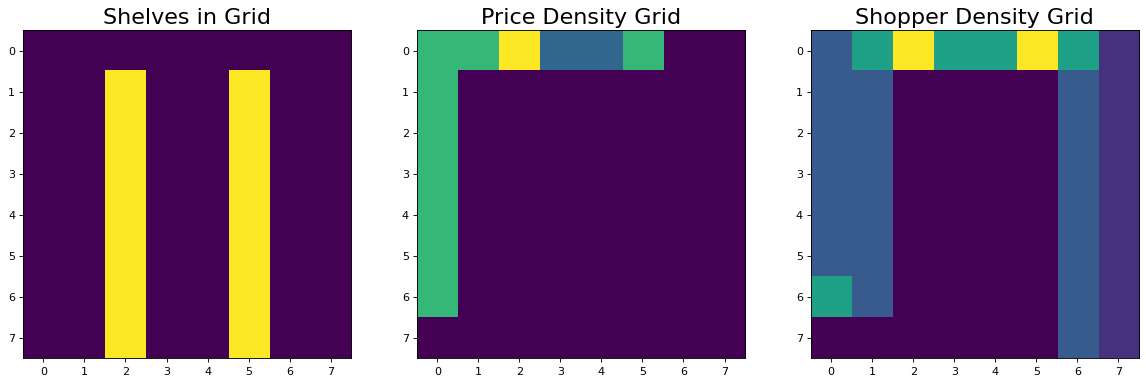

<Figure size 90000x90000 with 0 Axes>

In [68]:
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
plt.subplot(1, 3, 1)
plt.title("Shelves in Grid",fontsize=20)
plt.imshow(test_layout.a_star_grid)
plt.subplot(1, 3, 2)
plt.title("Price Density Grid",fontsize=20)
plt.imshow(price_density_grid)
plt.subplot(1, 3, 3)
plt.title("Shopper Density Grid",fontsize=20)
plt.imshow(shopper_density_grid)


plt.figure(num=None, figsize=(100, 100), dpi=900, facecolor='w', edgecolor='k')
plt.show()

## Simulate Layout in Figure 1
### Create and Process Layout

In [69]:
def split_row(word): 
    return [char for char in word]  

In [70]:
fig_1_layout =r'''
ffffffffffffffffffffffffffffffffffffffffffffffff
000000000000000000000000000000000000000000000000
0gg00000000000000000000000000000000000ffffff000f
0gg000000000000000000000000000000000000000ff000f
0gg000000000000000000000000000000000000000ff000f
0gg00dd0000eeeeee00000eeeeee00000000000000ff000f
0gg00dd0000eeeeee00000eeeeee00000000000000ff000f
0gg00dd0000000000000000000000000000000000000000f
00000dd0000eeeeee000000eeeeeeee0000cccc00000000f
00000dd0000eeeeee000000eeeeeeee0000cccc000ff000f

00000dd00000000000000000000000000000000000ff000f
0gg00dd0000eeeeee000000eeeeeeee00000000000ff000f
0gg00dd0000eeeeee000000eeeeeeee0000cccc000ff000f
0gg00dd0000000000000000000000000000cccc00000000f
0gg00dd0000eeeeee000000eeeeeeee0000000000000000f
0gg00000000eeeeee000000eeeeeeee00000000000ff000f
0gg00000000000000000000000000000000cccc000ff000f
00000000000eeeeee000000eeeeeeee0000cccc000ff000f
00000000000eeeeee000000eeeeeeee00000000000ff000f
00000000000000000000000000000000000000000000000f

0gg00bb0000eeeeee00000eeeeee0000000cccc00000000f
0gg00bb0000eeeeee00000eeeeee0000000cccc000ff000f
0gg00bb00000000000000000000000000000000000ff000f
0gg00bb00000000000000000000000000000000000ff000f
0gg00bb0000000000000000000000000000cccc000ff000f
0gg00bb0000000000000000000000000000cccc00000000f
00000bb00aa00aa00aa00aa00aa00aa0000000000000000f
00000bb00aa00aa00aa00aa00aa00aa00000000000ff000f
00000bb00aa00aa00aa00aa00aa00aa0000cccc000ff000f
0gg00bb00aa00aa00aa00aa00aa00aa0000cccc000ff000f

0gg000000aa00aa00aa00aa00aa00aa00000000000ff000f
0gg000000aa00aa00aa00aa00aa00aa0000000000000000f
0gg00000000000000000000000000000000cccc00000000f
0gg00000000000000000000000000000000cccc00000000f
0gg00000000000000000000000000000000000000000000f
0gg00gg00aa00aa00aa00aa00aa00aa0000000000000000f
0gg00gg00aa00aa00aa00aa00aa00aa0000ggcc00000000f
00000gg00aa00aa00aa00aa00aa00aa0000ggcc00000000f
00000gg00aa00aa00aa00aa00aa00aa0000000000000000f
00000000000000000000000000000000000000000000000f

00000000000000000000000000000000000000000000000f
00000000000000000000000000000000000000000000000f
00000000000000000000000000000000000000000000000f
00000000000000000000000000000000000000000000000f
000000000000000000000000000000000000000000000000
000000000000000000000000000000000000000000000000
000000000000000000000000000000000000000000000000
000000000000000000000000000000000000000000000000
'''
fig_1_layout = fig_1_layout.replace('\n\n', '\n')
fig_1_layout = fig_1_layout.strip("\n")

fig_1_layout = fig_1_layout.split("\n")
for i in range(len(fig_1_layout)):
    fig_1_layout[i] = split_row(fig_1_layout[i])


print(len(fig_1_layout))

48


In [71]:
department_dictionary = {
    "a": "Appliances",
    "b": "Audio",
    "c": "Cameras",
    "d": "Cell Phones",
    "e": "Computers&Tablets",
    "f": "TV&Home Theater",
    "g": "Video Gaming",
}
shelf_list = [shelf("")]
shelf_counter = 1
for (letter, department_name) in department_dictionary.items():
    for y in range(len(fig_1_layout)):
        for x in range(len(fig_1_layout)):
            if str(fig_1_layout[y][x]) == letter:
                print("found shelf", shelf_counter, "department:", department_name)
                fig_1_layout[y][x] = str(shelf_counter)
                shelf_counter += 1
                shelf_list.append(shelf(department_name))

for y in range(len(fig_1_layout)):
    for x in range(len(fig_1_layout)):
        if not str(fig_1_layout[y][x]).isdigit():
            fig_1_layout[y][x] = str(shelf_counter)
            shelf_counter +=1
        fig_1_layout[y][x] = int(fig_1_layout[y][x])
        
        
    
max_shelf_index = shelf_counter

found shelf 1 department: Appliances
found shelf 2 department: Appliances
found shelf 3 department: Appliances
found shelf 4 department: Appliances
found shelf 5 department: Appliances
found shelf 6 department: Appliances
found shelf 7 department: Appliances
found shelf 8 department: Appliances
found shelf 9 department: Appliances
found shelf 10 department: Appliances
found shelf 11 department: Appliances
found shelf 12 department: Appliances
found shelf 13 department: Appliances
found shelf 14 department: Appliances
found shelf 15 department: Appliances
found shelf 16 department: Appliances
found shelf 17 department: Appliances
found shelf 18 department: Appliances
found shelf 19 department: Appliances
found shelf 20 department: Appliances
found shelf 21 department: Appliances
found shelf 22 department: Appliances
found shelf 23 department: Appliances
found shelf 24 department: Appliances
found shelf 25 department: Appliances
found shelf 26 department: Appliances
found shelf 27 depart

found shelf 368 department: Computers&Tablets
found shelf 369 department: Computers&Tablets
found shelf 370 department: Computers&Tablets
found shelf 371 department: Computers&Tablets
found shelf 372 department: Computers&Tablets
found shelf 373 department: Computers&Tablets
found shelf 374 department: Computers&Tablets
found shelf 375 department: Computers&Tablets
found shelf 376 department: Computers&Tablets
found shelf 377 department: Computers&Tablets
found shelf 378 department: Computers&Tablets
found shelf 379 department: Computers&Tablets
found shelf 380 department: Computers&Tablets
found shelf 381 department: TV&Home Theater
found shelf 382 department: TV&Home Theater
found shelf 383 department: TV&Home Theater
found shelf 384 department: TV&Home Theater
found shelf 385 department: TV&Home Theater
found shelf 386 department: TV&Home Theater
found shelf 387 department: TV&Home Theater
found shelf 388 department: TV&Home Theater
found shelf 389 department: TV&Home Theater
found 

### Process Objects Based on Department to Place into Shelves

In [72]:
pdt_index = 0
pdt_list.sort(key=lambda x: x.department)

for shelf_index in range(1, max_shelf_index):
    print("\nShelf Index: ", shelf_index)
    cur_shelf = shelf_list[shelf_index]
    print("Shelf Department -- ", cur_shelf.department)
    
    for i in range(max_pdt_per_shelf):
        next_pdt = copy.deepcopy(pdt_list[pdt_index])
        print("Products Department", next_pdt.department)
        if cur_shelf.add_pdt(next_pdt) != -1:
            print("Added pdt id", next_pdt.index)
            pdt_index += 1
            if pdt_index == len(pdt_list):
                break
        else:
            break
    print("Products in shelf" , shelf_index, ":", cur_shelf.pdt_set)

    if pdt_index == len(pdt_list):
        print("--- Finished All Products with", shelf_index, "out of", max_shelf_index, "shelves --- ")
        break


Shelf Index:  1
Shelf Department --  Appliances
Products Department Appliances
Added pdt id 72
Products in shelf 1 : {72}

Shelf Index:  2
Shelf Department --  Appliances
Products Department Appliances
Added pdt id 72
Products in shelf 2 : {72}

Shelf Index:  3
Shelf Department --  Appliances
Products Department Appliances
Added pdt id 72
Products in shelf 3 : {72}

Shelf Index:  4
Shelf Department --  Appliances
Products Department Appliances
Added pdt id 72
Products in shelf 4 : {72}

Shelf Index:  5
Shelf Department --  Appliances
Products Department Appliances
Added pdt id 73
Products in shelf 5 : {73}

Shelf Index:  6
Shelf Department --  Appliances
Products Department Appliances
Added pdt id 73
Products in shelf 6 : {73}

Shelf Index:  7
Shelf Department --  Appliances
Products Department Appliances
Added pdt id 73
Products in shelf 7 : {73}

Shelf Index:  8
Shelf Department --  Appliances
Products Department Appliances
Added pdt id 74
Products in shelf 8 : {74}

Shelf Index:  9

Products Department Appliances
Added pdt id 127
Products in shelf 109 : {127}

Shelf Index:  110
Shelf Department --  Appliances
Products Department Appliances
Added pdt id 128
Products in shelf 110 : {128}

Shelf Index:  111
Shelf Department --  Appliances
Products Department Appliances
Added pdt id 128
Products in shelf 111 : {128}

Shelf Index:  112
Shelf Department --  Appliances
Products Department Appliances
Added pdt id 128
Products in shelf 112 : {128}

Shelf Index:  113
Shelf Department --  Appliances
Products Department Appliances
Added pdt id 129
Products in shelf 113 : {129}

Shelf Index:  114
Shelf Department --  Appliances
Products Department Appliances
Added pdt id 129
Products in shelf 114 : {129}

Shelf Index:  115
Shelf Department --  Appliances
Products Department Appliances
Added pdt id 130
Products in shelf 115 : {130}

Shelf Index:  116
Shelf Department --  Appliances
Products Department Appliances
Added pdt id 130
Products in shelf 116 : {130}

Shelf Index:  117


Shelf Department --  Cell Phones
Products Department Cell Phones
Added pdt id 88
Products in shelf 210 : {88}

Shelf Index:  211
Shelf Department --  Cell Phones
Products Department Cell Phones
Added pdt id 88
Products in shelf 211 : {88}

Shelf Index:  212
Shelf Department --  Cell Phones
Products Department Cell Phones
Added pdt id 88
Products in shelf 212 : {88}

Shelf Index:  213
Shelf Department --  Cell Phones
Products Department Cell Phones
Added pdt id 89
Products in shelf 213 : {89}

Shelf Index:  214
Shelf Department --  Cell Phones
Products Department Cell Phones
Added pdt id 89
Products in shelf 214 : {89}

Shelf Index:  215
Shelf Department --  Cell Phones
Products Department Cell Phones
Added pdt id 89
Products in shelf 215 : {89}

Shelf Index:  216
Shelf Department --  Cell Phones
Products Department Cell Phones
Added pdt id 89
Products in shelf 216 : {89}

Shelf Index:  217
Shelf Department --  Cell Phones
Products Department Cell Phones
Added pdt id 89
Products in shel

Added pdt id 91
Products in shelf 320 : {91}

Shelf Index:  321
Shelf Department --  Computers&Tablets
Products Department Computers&Tablets
Added pdt id 91
Products in shelf 321 : {91}

Shelf Index:  322
Shelf Department --  Computers&Tablets
Products Department Computers&Tablets
Added pdt id 92
Products in shelf 322 : {92}

Shelf Index:  323
Shelf Department --  Computers&Tablets
Products Department Computers&Tablets
Added pdt id 92
Products in shelf 323 : {92}

Shelf Index:  324
Shelf Department --  Computers&Tablets
Products Department Computers&Tablets
Added pdt id 92
Products in shelf 324 : {92}

Shelf Index:  325
Shelf Department --  Computers&Tablets
Products Department Computers&Tablets
Added pdt id 92
Products in shelf 325 : {92}

Shelf Index:  326
Shelf Department --  Computers&Tablets
Products Department Computers&Tablets
Added pdt id 93
Products in shelf 326 : {93}

Shelf Index:  327
Shelf Department --  Computers&Tablets
Products Department Computers&Tablets
Added pdt id 

Products Department TV&Home Theater
Added pdt id 20
Products in shelf 418 : {20}

Shelf Index:  419
Shelf Department --  TV&Home Theater
Products Department TV&Home Theater
Added pdt id 20
Products in shelf 419 : {20}

Shelf Index:  420
Shelf Department --  TV&Home Theater
Products Department TV&Home Theater
Added pdt id 20
Products in shelf 420 : {20}

Shelf Index:  421
Shelf Department --  TV&Home Theater
Products Department TV&Home Theater
Added pdt id 20
Products in shelf 421 : {20}

Shelf Index:  422
Shelf Department --  TV&Home Theater
Products Department TV&Home Theater
Added pdt id 21
Products in shelf 422 : {21}

Shelf Index:  423
Shelf Department --  TV&Home Theater
Products Department TV&Home Theater
Added pdt id 21
Products in shelf 423 : {21}

Shelf Index:  424
Shelf Department --  TV&Home Theater
Products Department TV&Home Theater
Added pdt id 21
Products in shelf 424 : {21}

Shelf Index:  425
Shelf Department --  TV&Home Theater
Products Department TV&Home Theater
Added

Shelf Department --  Video Gaming
Products Department Video Gaming
Added pdt id 69
Products in shelf 536 : {69}

Shelf Index:  537
Shelf Department --  Video Gaming
Products Department Video Gaming
Added pdt id 69
Products in shelf 537 : {69}

Shelf Index:  538
Shelf Department --  Video Gaming
Products Department Video Gaming
Added pdt id 69
Products in shelf 538 : {69}

Shelf Index:  539
Shelf Department --  Video Gaming
Products Department Video Gaming
Added pdt id 78
Products in shelf 539 : {78}

Shelf Index:  540
Shelf Department --  Video Gaming
Products Department Video Gaming
Added pdt id 78
Products in shelf 540 : {78}

Shelf Index:  541
Shelf Department --  Video Gaming
Products Department Video Gaming
Added pdt id 78
Products in shelf 541 : {78}

Shelf Index:  542
Shelf Department --  Video Gaming
Products Department Video Gaming
Added pdt id 78
Products in shelf 542 : {78}

Shelf Index:  543
Shelf Department --  Video Gaming
Products Department Video Gaming
Added pdt id 79


### Run Simulation of Shoppers

In [73]:
## Test Layout with Model
counters = [(44, 6),(44, 7),(44, 8),(44, 9),(44, 10), (44, 11), (44,12), (44,13)]
#counters = [(40, 6),(40, 7),(40, 8),(40, 9),(40, 10), (40, 11), (40,12), (40,13)]
# counters = [(24, 24),(24, 25),(24, 26),(24, 23),(24, 22)]
entrances = [[47,30],[47,29],[47,28]]
exit = [[48,35],[48,36],[48,37]]
fig_1_layout_object = layout(fig_1_layout, counters, entrances, exit, shelf_list, pdt_list)
print("Number of products in layout:", len(fig_1_layout_object.pdt_list))

Number of products in layout: 570


In [74]:
fig_1_layout_object.new_shopper()

--Testing New Shopper--
Size of Shopper: 56
Chosen Product: 113
Shelf Containing Product: 45
Visited  29 24
deleting pdt from list 113
ran out of product 113
Chosen Product: 116
Shelf Containing Product: 66
Visited  32 18
deleting pdt from list 116
ran out of product 116
next pdt too heavy
Visited  43 10
Visited  47 36
--Finishing Shopper--


0

In [75]:
gc.collect()
for i in range(600):
    try:
        shopper_density_grid = fig_1_layout_object.new_shopper()
        if shopper_density_grid == -1:
            print("Exhausted Shop with approximately", i, "shoppers")
            break
    except:
        pass
price_density_grid = fig_1_layout_object.get_price_grid()
shopper_density_grid = fig_1_layout_object.get_shopper_grid()

--Testing New Shopper--
Size of Shopper: 46
Chosen Product: 113
Shelf Containing Product: 44
Visited  29 23
deleting pdt from list 113
ran out of product 113
Chosen Product: 116
Shelf Containing Product: 65
Visited  32 17
deleting pdt from list 116
ran out of product 116
next pdt too heavy
Visited  43 7
Visited  47 36
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 59
Chosen Product: 116
Shelf Containing Product: 64
Visited  32 14
deleting pdt from list 116
ran out of product 116
Chosen Product: 116
Shelf Containing Product: 63
Visited  32 13
deleting pdt from list 116
ran out of product 116
next pdt too heavy
Visited  43 7
Visited  47 37
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 59
Chosen Product: 116
Shelf Containing Product: 62
Visited  32 10
deleting pdt from list 116
ran out of product 116
Chosen Product: 116
Shelf Containing Product: 61
Visited  32 9
deleting pdt from list 116
ran out of product 116
next pdt too heavy
Visited  43 6
Visited  47 

Visited  17 2
deleting pdt from list 78
ran out of product 78
Chosen Product: 78
Shelf Containing Product: 539
Visited  17 1
deleting pdt from list 78
Visited  43 12
Visited  47 35
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 47
Chosen Product: 30
Shelf Containing Product: 458
Visited  11 46
deleting pdt from list 30
Chosen Product: 78
Shelf Containing Product: 539
Visited  17 1
deleting pdt from list 78
Chosen Product: 131
Shelf Containing Product: 119
Visited  39 29
deleting pdt from list 131
Visited  43 7
Visited  47 36
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 43
Chosen Product: 107
Shelf Containing Product: 28
Visited  28 15
deleting pdt from list 107
ran out of product 107
Chosen Product: 112
Shelf Containing Product: 39
Visited  29 12
deleting pdt from list 112
Chosen Product: 78
Shelf Containing Product: 539
Visited  17 1
deleting pdt from list 78
ran out of product 78
Visited  43 6
Visited  47 35
--Finishing Shopper--
--Testing New Shoppe

Visited  9 46
deleting pdt from list 29
ran out of product 29
Visited  43 11
Visited  47 37
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 60
Chosen Product: 79
Shelf Containing Product: 546
Visited  22 3
deleting pdt from list 79
ran out of product 79
Chosen Product: 29
Shelf Containing Product: 451
Visited  8 43
deleting pdt from list 29
Chosen Product: 25
Shelf Containing Product: 439
Visited  4 41
deleting pdt from list 25
Visited  43 11
Visited  47 36
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 50
Chosen Product: 79
Shelf Containing Product: 545
Visited  22 0
deleting pdt from list 79
Chosen Product: 27
Shelf Containing Product: 445
Visited  7 42
deleting pdt from list 27
ran out of product 27
Chosen Product: 107
Shelf Containing Product: 27
Visited  28 12
deleting pdt from list 107
Visited  43 11
Visited  47 36
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 49
Chosen Product: 79
Shelf Containing Product: 545
Visited  22 0
deletin

Visited  43 10
Visited  47 36
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 53
Chosen Product: 92
Shelf Containing Product: 325
Visited  16 27
deleting pdt from list 92
Chosen Product: 92
Shelf Containing Product: 325
Visited  16 27
deleting pdt from list 92
ran out of product 92
Chosen Product: 92
Shelf Containing Product: 324
Visited  16 26
deleting pdt from list 92
Visited  43 12
Visited  47 36
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 55
Chosen Product: 40
Shelf Containing Product: 262
Visited  10 14
deleting pdt from list 40
Chosen Product: 92
Shelf Containing Product: 324
Visited  16 26
deleting pdt from list 92
Chosen Product: 92
Shelf Containing Product: 324
Visited  16 26
deleting pdt from list 92
ran out of product 92
Visited  43 11
Visited  47 37
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 47
Chosen Product: 21
Shelf Containing Product: 425
Visited  1 44
deleting pdt from list 21
Chosen Product: 92
Shelf Containing Pro

Visited  13 26
deleting pdt from list 71
Chosen Product: 81
Shelf Containing Product: 552
Visited  26 2
deleting pdt from list 81
Chosen Product: 71
Shelf Containing Product: 310
Visited  13 26
deleting pdt from list 71
Visited  43 13
Visited  47 35
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 57
Chosen Product: 82
Shelf Containing Product: 559
Visited  32 0
deleting pdt from list 82
Chosen Product: 71
Shelf Containing Product: 310
Visited  13 26
deleting pdt from list 71
ran out of product 71
Chosen Product: 82
Shelf Containing Product: 559
Visited  32 0
deleting pdt from list 82
Visited  43 11
Visited  47 37
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 46
Chosen Product: 82
Shelf Containing Product: 559
Visited  32 0
deleting pdt from list 82
ran out of product 82
Chosen Product: 71
Shelf Containing Product: 309
Visited  13 25
deleting pdt from list 71
Chosen Product: 81
Shelf Containing Product: 552
Visited  26 2
deleting pdt from list 81
Visited 

Visited  16 27
deleting pdt from list 96
Visited  43 8
Visited  47 37
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 45
Chosen Product: 0
Shelf Containing Product: 383
Visited  1 2
deleting pdt from list 0
Chosen Product: 0
Shelf Containing Product: 383
Visited  1 2
deleting pdt from list 0
ran out of product 0
Chosen Product: 96
Shelf Containing Product: 339
Visited  16 27
deleting pdt from list 96
ran out of product 96
Visited  43 12
Visited  47 35
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 56
Chosen Product: 130
Shelf Containing Product: 117
Visited  39 25
deleting pdt from list 130
Chosen Product: 130
Shelf Containing Product: 117
Visited  39 25
deleting pdt from list 130
ran out of product 130
Chosen Product: 96
Shelf Containing Product: 338
Visited  16 26
deleting pdt from list 96
Visited  43 8
Visited  47 36
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 59
Chosen Product: 68
Shelf Containing Product: 531
Visited  12 0
deleting

Visited  39 17
deleting pdt from list 129
ran out of product 129
Chosen Product: 39
Shelf Containing Product: 260
Visited  10 12
deleting pdt from list 39
Chosen Product: 69
Shelf Containing Product: 532
Visited  12 3
deleting pdt from list 69
Visited  43 11
Visited  47 37
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 42
Chosen Product: 36
Shelf Containing Product: 484
Visited  23 41
deleting pdt from list 36
ran out of product 36
Chosen Product: 39
Shelf Containing Product: 260
Visited  10 12
deleting pdt from list 39
Chosen Product: 75
Shelf Containing Product: 10
Visited  25 26
deleting pdt from list 75
ran out of product 75
Visited  43 12
Visited  47 35
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 55
Chosen Product: 39
Shelf Containing Product: 260
Visited  10 12
deleting pdt from list 39
ran out of product 39
Chosen Product: 39
Shelf Containing Product: 259
Visited  10 11
deleting pdt from list 39
Chosen Product: 39
Shelf Containing Product: 259


Visited  23 3
deleting pdt from list 80
Chosen Product: 35
Shelf Containing Product: 481
Visited  22 41
deleting pdt from list 35
Chosen Product: 108
Shelf Containing Product: 29
Visited  28 16
deleting pdt from list 108
Visited  43 8
Visited  47 35
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 57
Chosen Product: 35
Shelf Containing Product: 481
Visited  22 41
deleting pdt from list 35
Chosen Product: 108
Shelf Containing Product: 29
Visited  28 16
deleting pdt from list 108
ran out of product 108
Chosen Product: 35
Shelf Containing Product: 481
Visited  22 41
deleting pdt from list 35
ran out of product 35
Visited  43 13
Visited  47 36
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 44
Chosen Product: 54
Shelf Containing Product: 144
Visited  7 38
deleting pdt from list 54
ran out of product 54
Chosen Product: 35
Shelf Containing Product: 480
Visited  21 46
deleting pdt from list 35
Chosen Product: 80
Shelf Containing Product: 548
Visited  23 3
deleting

Visited  47 36
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 55
Chosen Product: 47
Shelf Containing Product: 294
Visited  13 24
deleting pdt from list 47
Chosen Product: 33
Shelf Containing Product: 469
Visited  16 46
deleting pdt from list 33
Chosen Product: 47
Shelf Containing Product: 294
Visited  13 24
deleting pdt from list 47
ran out of product 47
Visited  43 8
Visited  47 35
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 56
Chosen Product: 33
Shelf Containing Product: 469
Visited  16 46
deleting pdt from list 33
Chosen Product: 33
Shelf Containing Product: 469
Visited  16 46
deleting pdt from list 33
ran out of product 33
Chosen Product: 33
Shelf Containing Product: 468
Visited  16 44
deleting pdt from list 33
Visited  43 6
Visited  47 36
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 55
Chosen Product: 47
Shelf Containing Product: 293
Visited  13 23
deleting pdt from list 47
Chosen Product: 32
Shelf Containing Product: 463
Visite

Visited  31 43
deleting pdt from list 50
ran out of product 50
Chosen Product: 41
Shelf Containing Product: 270
Visited  10 28
deleting pdt from list 41
Chosen Product: 41
Shelf Containing Product: 270
Visited  10 28
deleting pdt from list 41
ran out of product 41
Visited  43 10
Visited  47 37
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 58
Chosen Product: 41
Shelf Containing Product: 269
Visited  10 27
deleting pdt from list 41
Chosen Product: 41
Shelf Containing Product: 269
Visited  10 27
deleting pdt from list 41
Chosen Product: 41
Shelf Containing Product: 269
Visited  10 27
deleting pdt from list 41
ran out of product 41
Visited  43 7
Visited  47 37
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 49
Chosen Product: 48
Shelf Containing Product: 493
Visited  26 43
deleting pdt from list 48
Chosen Product: 48
Shelf Containing Product: 493
Visited  26 43
deleting pdt from list 48
Chosen Product: 41
Shelf Containing Product: 268
Visited  10 26
deleting

Visited  47 37
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 46
Chosen Product: 66
Shelf Containing Product: 521
Visited  4 0
deleting pdt from list 66
Chosen Product: 66
Shelf Containing Product: 521
Visited  4 0
deleting pdt from list 66
ran out of product 66
Chosen Product: 66
Shelf Containing Product: 520
Visited  3 3
deleting pdt from list 66
Visited  43 13
Visited  47 35
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 47
Chosen Product: 46
Shelf Containing Product: 288
Visited  13 12
deleting pdt from list 46
Chosen Product: 46
Shelf Containing Product: 288
Visited  13 12
deleting pdt from list 46
ran out of product 46
Chosen Product: 66
Shelf Containing Product: 520
Visited  3 3
deleting pdt from list 66
Visited  43 9
Visited  47 37
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 40
Chosen Product: 66
Shelf Containing Product: 520
Visited  3 3
deleting pdt from list 66
ran out of product 66
Chosen Product: 90
Shelf Containing Produc

Visited  36 31
deleting pdt from list 122
ran out of product 122
Visited  43 9
Visited  47 37
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 52
Chosen Product: 12
Shelf Containing Product: 389
Visited  1 8
deleting pdt from list 12
ran out of product 12
Chosen Product: 38
Shelf Containing Product: 492
Visited  26 42
deleting pdt from list 38
Chosen Product: 38
Shelf Containing Product: 492
Visited  26 42
deleting pdt from list 38
ran out of product 38
Visited  43 8
Visited  47 37
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 46
Chosen Product: 73
Shelf Containing Product: 6
Visited  25 18
deleting pdt from list 73
Chosen Product: 12
Shelf Containing Product: 388
Visited  1 7
deleting pdt from list 12
Chosen Product: 12
Shelf Containing Product: 388
Visited  1 7
deleting pdt from list 12
Visited  43 11
Visited  47 37
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 50
Chosen Product: 12
Shelf Containing Product: 388
Visited  1 7
deleting pd

Visited  1 13
deleting pdt from list 13
ran out of product 13
Chosen Product: 118
Shelf Containing Product: 77
Visited  34 17
deleting pdt from list 118
Chosen Product: 118
Shelf Containing Product: 77
Visited  34 17
deleting pdt from list 118
ran out of product 118
Visited  43 6
Visited  47 35
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 47
Chosen Product: 13
Shelf Containing Product: 393
Visited  1 12
deleting pdt from list 13
Chosen Product: 14
Shelf Containing Product: 399
Visited  1 18
deleting pdt from list 14
Chosen Product: 14
Shelf Containing Product: 399
Visited  1 18
deleting pdt from list 14
Visited  43 11
Visited  47 37
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 57
Chosen Product: 50
Shelf Containing Product: 499
Visited  29 44
deleting pdt from list 50
ran out of product 50
Chosen Product: 14
Shelf Containing Product: 399
Visited  1 18
deleting pdt from list 14
ran out of product 14
Chosen Product: 14
Shelf Containing Product: 398
Vis

Visited  39 13
deleting pdt from list 128
Visited  43 13
Visited  47 36
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 41
Chosen Product: 98
Shelf Containing Product: 24
Visited  27 31
deleting pdt from list 98
ran out of product 98
Chosen Product: 128
Shelf Containing Product: 111
Visited  39 13
deleting pdt from list 128
Chosen Product: 98
Shelf Containing Product: 23
Visited  27 28
deleting pdt from list 98
Visited  43 6
Visited  47 37
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 49
Chosen Product: 128
Shelf Containing Product: 111
Visited  39 13
deleting pdt from list 128
ran out of product 128
Chosen Product: 98
Shelf Containing Product: 23
Visited  27 28
deleting pdt from list 98
Chosen Product: 121
Shelf Containing Product: 90
Visited  36 19
deleting pdt from list 121
Visited  43 9
Visited  47 37
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 40
Chosen Product: 128
Shelf Containing Product: 110
Visited  39 10
deleting pdt from li

Visited  6 0
deleting pdt from list 67
Chosen Product: 26
Shelf Containing Product: 441
Visited  4 46
deleting pdt from list 26
Chosen Product: 67
Shelf Containing Product: 525
Visited  6 0
deleting pdt from list 67
ran out of product 67
Visited  43 6
Visited  47 36
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 57
Chosen Product: 67
Shelf Containing Product: 524
Visited  5 3
deleting pdt from list 67
Chosen Product: 67
Shelf Containing Product: 524
Visited  5 3
deleting pdt from list 67
Chosen Product: 16
Shelf Containing Product: 403
Visited  1 22
deleting pdt from list 16
ran out of product 16
Visited  43 10
Visited  47 35
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 48
Chosen Product: 42
Shelf Containing Product: 274
Visited  10 12
deleting pdt from list 42
Chosen Product: 42
Shelf Containing Product: 274
Visited  10 12
deleting pdt from list 42
Chosen Product: 67
Shelf Containing Product: 524
Visited  5 3
deleting pdt from list 67
ran out of produ

Visited  43 11
Visited  47 35
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 56
Chosen Product: 4
Shelf Containing Product: 234
Visited  7 12
deleting pdt from list 4
Chosen Product: 61
Shelf Containing Product: 182
Visited  27 36
deleting pdt from list 61
Chosen Product: 10
Shelf Containing Product: 254
Visited  7 26
deleting pdt from list 10
ran out of product 10
Visited  43 11
Visited  47 35
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 59
Chosen Product: 10
Shelf Containing Product: 253
Visited  7 25
deleting pdt from list 10
Chosen Product: 10
Shelf Containing Product: 253
Visited  7 25
deleting pdt from list 10
Chosen Product: 86
Shelf Containing Product: 578
Visited  38 36
deleting pdt from list 86
Visited  43 11
Visited  47 35
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 43
Chosen Product: 85
Shelf Containing Product: 570
Visited  37 2
deleting pdt from list 85
ran out of product 85
Chosen Product: 86
Shelf Containing Product: 

Visited  22 12
deleting pdt from list 106
Chosen Product: 53
Shelf Containing Product: 514
Visited  41 46
deleting pdt from list 53
Chosen Product: 37
Shelf Containing Product: 485
Visited  23 44
deleting pdt from list 37
Visited  43 12
Visited  47 35
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 40
Chosen Product: 106
Shelf Containing Product: 370
Visited  22 12
deleting pdt from list 106
Chosen Product: 106
Shelf Containing Product: 370
Visited  22 12
deleting pdt from list 106
ran out of product 106
Chosen Product: 37
Shelf Containing Product: 485
Visited  23 44
deleting pdt from list 37
Visited  43 6
Visited  47 37
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 44
Chosen Product: 53
Shelf Containing Product: 514
Visited  41 46
deleting pdt from list 53
Chosen Product: 106
Shelf Containing Product: 369
Visited  22 11
deleting pdt from list 106
Chosen Product: 106
Shelf Containing Product: 369
Visited  22 11
deleting pdt from list 106
Visited  43 12
V

Visited  34 3
deleting pdt from list 83
Chosen Product: 52
Shelf Containing Product: 508
Visited  35 46
deleting pdt from list 52
Visited  43 12
Visited  47 37
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 43
Chosen Product: 55
Shelf Containing Product: 145
Visited  10 35
deleting pdt from list 55
Chosen Product: 52
Shelf Containing Product: 508
Visited  35 46
deleting pdt from list 52
ran out of product 52
Chosen Product: 83
Shelf Containing Product: 564
Visited  34 3
deleting pdt from list 83
Visited  43 8
Visited  47 35
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 45
Chosen Product: 83
Shelf Containing Product: 564
Visited  34 3
deleting pdt from list 83
ran out of product 83
Chosen Product: 52
Shelf Containing Product: 507
Visited  34 46
deleting pdt from list 52
Chosen Product: 4
Shelf Containing Product: 233
Visited  7 11
deleting pdt from list 4
Visited  43 13
Visited  47 36
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 46
Chos

Visited  15 37
deleting pdt from list 57
Chosen Product: 104
Shelf Containing Product: 360
Visited  19 14
deleting pdt from list 104
ran out of product 104
Visited  43 8
Visited  47 35
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 48
Chosen Product: 62
Shelf Containing Product: 190
Visited  31 36
deleting pdt from list 62
Chosen Product: 62
Shelf Containing Product: 190
Visited  31 36
deleting pdt from list 62
ran out of product 62
Chosen Product: 62
Shelf Containing Product: 189
Visited  31 35
deleting pdt from list 62
Visited  43 9
Visited  47 37
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 40
Chosen Product: 60
Shelf Containing Product: 180
Visited  26 38
deleting pdt from list 60
Chosen Product: 60
Shelf Containing Product: 180
Visited  26 38
deleting pdt from list 60
Chosen Product: 57
Shelf Containing Product: 159
Visited  15 37
deleting pdt from list 57
Visited  43 7
Visited  47 36
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 

Visited  22 24
deleting pdt from list 124
Chosen Product: 101
Shelf Containing Product: 348
Visited  19 16
deleting pdt from list 101
ran out of product 101
Visited  43 10
Visited  47 35
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 56
Chosen Product: 9
Shelf Containing Product: 248
Visited  7 14
deleting pdt from list 9
Chosen Product: 9
Shelf Containing Product: 248
Visited  7 14
deleting pdt from list 9
ran out of product 9
Chosen Product: 5
Shelf Containing Product: 236
Visited  7 14
deleting pdt from list 5
Visited  43 6
Visited  47 35
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 48
Chosen Product: 5
Shelf Containing Product: 236
Visited  7 14
deleting pdt from list 5
Chosen Product: 124
Shelf Containing Product: 377
Visited  22 24
deleting pdt from list 124
ran out of product 124
Chosen Product: 7
Shelf Containing Product: 243
Visited  7 26
deleting pdt from list 7
Visited  43 13
Visited  47 36
--Finishing Shopper--
--Testing New Shopper--
Size 

Visited  22 7
deleting pdt from list 132
Visited  43 8
Visited  47 37
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 42
Chosen Product: 132
Shelf Containing Product: 126
Visited  22 7
deleting pdt from list 132
ran out of product 132
Chosen Product: 132
Shelf Containing Product: 125
Visited  22 4
deleting pdt from list 132
Chosen Product: 132
Shelf Containing Product: 125
Visited  22 4
deleting pdt from list 132
Visited  43 7
Visited  47 35
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 52
Chosen Product: 132
Shelf Containing Product: 125
Visited  22 4
deleting pdt from list 132
ran out of product 132
Chosen Product: 132
Shelf Containing Product: 124
Visited  21 7
deleting pdt from list 132
Chosen Product: 132
Shelf Containing Product: 124
Visited  21 7
deleting pdt from list 132
Visited  43 7
Visited  47 35
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 55
Chosen Product: 132
Shelf Containing Product: 124
Visited  21 7
deleting pdt from 

Shelf Containing Product: 204
Visited  6 7
deleting pdt from list 87
Chosen Product: 87
Shelf Containing Product: 204
Visited  6 7
deleting pdt from list 87
ran out of product 87
Visited  43 12
Visited  47 37
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 60
Chosen Product: 87
Shelf Containing Product: 203
Visited  6 4
deleting pdt from list 87
Chosen Product: 59
Shelf Containing Product: 172
Visited  22 38
deleting pdt from list 59
Chosen Product: 87
Shelf Containing Product: 203
Visited  6 4
deleting pdt from list 87
Visited  43 10
Visited  47 36
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 60
Chosen Product: 87
Shelf Containing Product: 203
Visited  6 4
deleting pdt from list 87
ran out of product 87
Chosen Product: 59
Shelf Containing Product: 172
Visited  22 38
deleting pdt from list 59
Chosen Product: 59
Shelf Containing Product: 172
Visited  22 38
deleting pdt from list 59
ran out of product 59
Visited  43 10
Visited  47 36
--Finishing Shopper--

Visited  10 4
deleting pdt from list 88
Chosen Product: 89
Shelf Containing Product: 215
Visited  12 4
deleting pdt from list 89
Visited  43 10
Visited  47 35
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 59
Chosen Product: 89
Shelf Containing Product: 215
Visited  12 4
deleting pdt from list 89
ran out of product 89
Chosen Product: 88
Shelf Containing Product: 211
Visited  10 4
deleting pdt from list 88
Chosen Product: 133
Shelf Containing Product: 131
Visited  25 4
deleting pdt from list 133
ran out of product 133
Visited  43 10
Visited  47 36
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 50
Chosen Product: 133
Shelf Containing Product: 130
Visited  24 7
deleting pdt from list 133
Chosen Product: 88
Shelf Containing Product: 211
Visited  10 4
deleting pdt from list 88
ran out of product 88
Chosen Product: 88
Shelf Containing Product: 210
Visited  9 7
deleting pdt from list 88
Visited  43 13
Visited  47 36
--Finishing Shopper--
--Testing New Shopper--

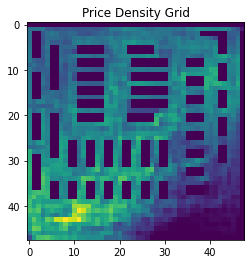

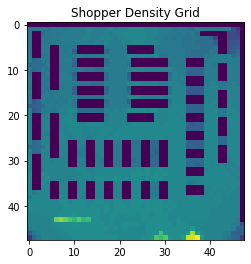

In [76]:
plt.imshow(price_density_grid)
plt.title("Price Density Grid")
plt.show()

plt.imshow(shopper_density_grid)
plt.title("Shopper Density Grid")
plt.show()

### Analysis of Crowd Density

In [77]:
total=0
for pdt in pdt_list:
    total += pdt.discounted_price*pdt.qty
    
print("No of products:", len(pdt_list))
print("Number of products in layout:", len(fig_1_layout_object.pdt_list))
print("Total Value", total)
print("Value of Goods bought",fig_1_layout_object.value_of_goods_bought )
print("Total Loss:", fig_1_layout_object.total_loss())

No of products: 570
Number of products in layout: 0
Total Value 891784.6099999908
Value of Goods bought 891784.6099999876
Total Loss: 4328.695955555546


In [78]:
print("Standard Deviation of Shopper Density:", np.std(shopper_density_grid, axis=(0,1)))
print("Standard Deviation of Price Density:", np.std(price_density_grid, axis=(0,1)))

Standard Deviation of Shopper Density: 9.306722488745992
Standard Deviation of Price Density: 305.78266345631823


### Debugging Cells

In [79]:
for pdt in fig_1_layout_object.pdt_list:
    print(pdt.index)

In [80]:
for shelf in fig_1_layout_object.shelf_list:
    print (shelf.pdt_set)

set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set(

In [81]:
for pdt in pdt_list:
    if pdt.index == 78:
        print(pdt.department)

Video Gaming
Video Gaming
Video Gaming
Video Gaming
